# Default scipy optimization

Overview:

1. Start with a specific set of kinematic variables.  
2. Pick random starting points for CFFs
3. Compute TotalUUXS function for each phi in the kinematic set (using current CFFs) to produce Fs
4. Compare resulting Fs to sampled Fs and compute mean-squared error
5. Update CFFs in a direction that reduces that mean-squared error
6. Repeat steps 3-5 until CFFs stop changing

In [2]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import scipy.optimize as optimization

from BHDVCStf import BHDVCS #modified bhdvcs file
import utilities as uts

## Setup

In [11]:
bhdvcs = BHDVCS()

df = pd.read_csv("dvcs_xs_newsets_genCFFs.csv")
data = uts.DvcsData(df)

numSets = 15
numReplicas = 500

## Produce Results

In [8]:
df

#Set  index     k       QQ       x_b         t  phi_x         F  \
0       0      0  3.75  1.74013  0.435095 -0.380868      0  0.058205   
1       0      1  3.75  1.74013  0.435095 -0.380868     10  0.055596   
2       0      2  3.75  1.74013  0.435095 -0.380868     20  0.066353   
3       0      3  3.75  1.74013  0.435095 -0.380868     30  0.068655   
4       0      4  3.75  1.74013  0.435095 -0.380868     40  0.072765   
..    ...    ...   ...      ...       ...       ...    ...       ...   
535    14     31  7.75  2.63258  0.345012 -0.361188    310  0.023981   
536    14     32  7.75  2.63258  0.345012 -0.361188    320  0.025345   
537    14     33  7.75  2.63258  0.345012 -0.361188    330  0.024191   
538    14     34  7.75  2.63258  0.345012 -0.361188    340  0.020530   
539    14     35  7.75  2.63258  0.345012 -0.361188    350  0.020891   

         errF        F1       F2      dvcs      ReH      ReE  ReHtilde  
0    0.002910  0.498060  0.68579  0.012288  13.0554 -53.0554   7.25302  
1    0.002780  0.498060  0.68579  0.012288  13.0554 -53.0554   7.25302  
2    0.003318  0.498060  0.68579  0.012288  13.0554 -53.0554   7.25302  
3    0.003433  0.498060  0.68579  0.012288  13.0554 -53.0554   7.25302  
4    0.003638  0.498060  0.68579  0.012288  13.0554 -53.0554   7.25302  
..        ...       ...      ...       ...      ...      ...       ...  
535  0.001199  0.512913  0.71481  0.012288  11.7411 -51.7411   6.52283  
536  0.001267  0.512913  0.71481  0.012288  11.7411 -51.7411   6.52283  
537  0.001210  0.512913  0.71481  0.012288  11.7411 -51.7411   6.52283  
538  0.001027  0.512913  0.71481  0.012288  11.7411 -51.7411   6.52283  
539  0.001045  0.512913  0.71481  0.012288  11.7411 -51.7411   6.52283  

[540 rows x 15 columns]

In [9]:
def produceResults(data, numSets, numReplicas):
    '''
    :param data: data of class DvcsData (which can be found in utilities.py)
    :param numSets: number of different kinematic sets contained in data
    :param numReplicas: number of replicas you would like to produce
    
    :returns: numpy array with shape (numSets, numReplicas, numCFFs)
    '''
    results = []
    for i in tqdm(range(numSets)):
        replicas = []
        seti = data.getSet(i) # DvcsData object of kinematic set i
        X = np.array(seti.XnoCFF) # the kinematics and all variables necessary to compute 
        sigma = seti.erry # error in F
        pars = np.array([1, 1, 1])
        for i in range(numReplicas):
            y = seti.sampleY()
            cff, cffcov = optimization.curve_fit(bhdvcs.TotalUUXS, X, y, pars, sigma, method='lm')
            replicas.append(cff)
        results.append(replicas)
    return np.array(results)

In [12]:
results = produceResults(data, numSets, numReplicas)

# ReH

In [84]:
y_yhat, err = uts.y_yhat_errCFFs(data, results, 0)

Mean percent error:  9.195302559558819
RMSE:  0.9690429107323163
RMSE w yhat=mean:  2.5254628436780107
R-squared:  0.8527673764422696


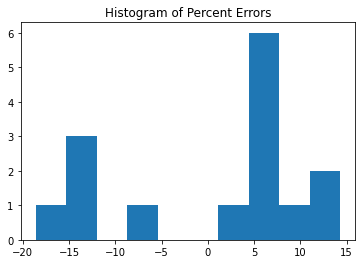

In [85]:
uts.evaluate(y_yhat)

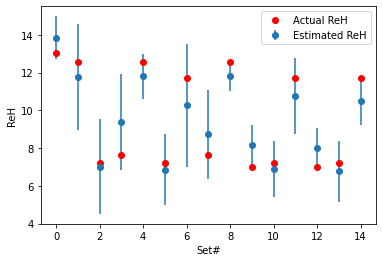

In [86]:
uts.plotError(y_yhat, err, "ReH")

# ReE

Mean percent error:  9.823305381794109
RMSE:  5.334005203404967
RMSE w yhat=mean:  2.525480507907797
R-squared:  -3.460862410773733


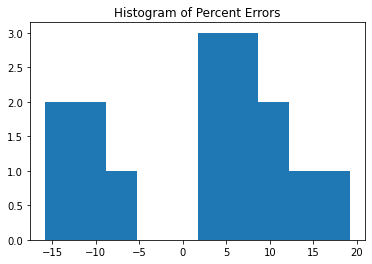

In [87]:
y_yhat, err = uts.y_yhat_errCFFs(data, results, 1)
uts.evaluate(y_yhat)

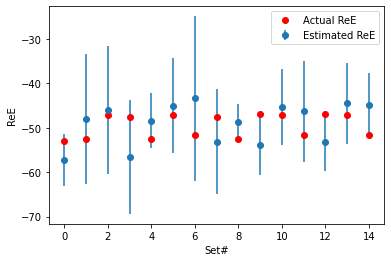

In [88]:
uts.plotError(y_yhat, err, "ReE")

# ReHtilde

Mean percent error:  7.540141059055228
RMSE:  0.40294307153845793
RMSE w yhat=mean:  1.4030345621243816
R-squared:  0.9175196213052079


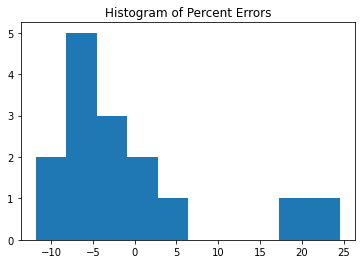

In [89]:
y_yhat, err = uts.y_yhat_errCFFs(data, results, 2)
uts.evaluate(y_yhat)

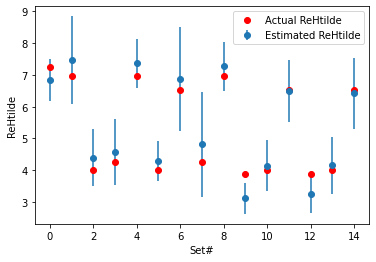

In [90]:
uts.plotError(y_yhat, err, "ReHtilde")

# Propagated Fs at 180

Mean percent error:  5.603559065119957
RMSE:  0.002519413780113987
RMSE w yhat=mean:  0.015855649879790133
R-squared:  0.9747517718286317


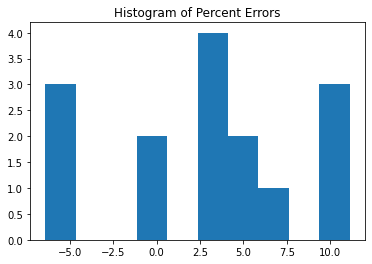

In [91]:
y_yhat, err = uts.y_yhat_errFs(results, data)
uts.evaluate(y_yhat)

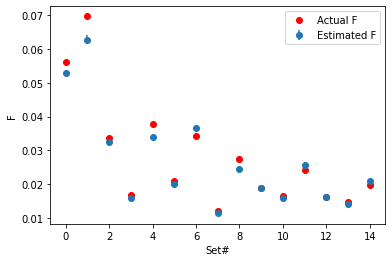

In [92]:
uts.plotError(y_yhat, err, "F")

# Save Results to file for later use

In [72]:
results.tofile('replicas500.txt')